<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Pregunta 3 - Redes Convolucionales y sus aplicaciones </H3>
<H3 align='center'>  Jorge Portilla - John Rodriguez </H3>

<hr style="height:2px;border:none"/>

<a id="cuarto"></a>
# CNN sobre texto

> Cuando oimos sobre redes neuronales convolucionales (CNN) normalmente pensamos en visión artificial. Las CNN fueron responsables de los principales avances en la clasificación de imágenes y son el núcleo de la mayoría de los sistemas de *Computer Vision* en la actualidad, desde el etiquetado automático de fotos de Facebook hasta los autos que conducen por sí mismos.

> Más recientemente, también hemos empezado a aplicar CNN a problemas de procesamiento del lenguaje natural (NLP) y hemos obtenido resultados interesantes. Como sabemos, las redes convolucionales tienen importantes ventajas como invarianza a rotaciones y traslaciones así como la conectividad local (características de nivel inferior en una representación de nivel superior), además de lo que las hace fuertemente ventajosas, el **compartir** parámetros.


> **¿Cómo se aplica esto a NLP?**  
En esta experimentación apicaremos una red CNN al dataset  __[Adzuna](https://www.kaggle.com/c/job-salary-prediction)__ que contiene cientos de miles de registros que en su mayoría corresponden a texto no estructurado versus sólo unos pocos estructurados. Los registros pueden estar en varios formatos diferentes debido a los cientos de diferentes fuentes de registros, los cuales corresponden a anuncios de empleadores en busca de trabajadores.  
Es decir, cada fila es un anuncio que, en estricto rigor, representa una sentencia típicamente trabajada como vectores de word embeddings como **word2vec** o **GloVe**. Así, para una frase de 10 palabras bajo representaciones de *embeddings* utilizando 100 dimensiones tendríamos una matriz de 10 × 100 como entrada, lo que simularía nuestra "imagen".

> Su tarea es entonces, predecir el salario (valor continuo) de un determinado anuncio en base al texto indicado en éste. Igualmente puede valerse de otros atributos del anuncio como por ejemplo la ubicación, tipo de contrato, etc. 

> Intente resolver el problema experimentando con las ayudas que se entregan en el código y lo aprendido hasta ahora en el curso. Se espera que llegue a un MAE menor a 7000 en el conjunto de pruebas. No olvide documentar todo lo experimentando en este Informe Jupyter así como el argumento de sus decisiones.

Lo primero que se hace es cargar las librerías y modulos necesarios para comenzar a experimentar

In [1]:
#Librerías y modulos
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import re, os, sys
import keras
import matplotlib.pyplot as plt
import math
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
from nltk import WordNetLemmatizer
from nltk import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


La función *TestCallback* por primera vez introducidad en la pregunta 1 de la presente tarea sirve para observar el error y el accuracy en el conjunto de testing al momento de realizar el entrenamiento de una red.

In [26]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_loss.append(loss)
        test_acc.append(acc)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

Se verifica si se tiene descargados los stepwords y wornet en el entorno local.

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

Primeras filas de la data a analizar.

In [3]:
df = pd.read_csv("Train_rev1.csv")
df.pop("Id")
df.head()

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


La función pre_preprocesar se encarga de limpiar los textos del dataframe, quitando caracteres irrelevantes y eliminando stopwords. A su vez, utlizamos el *Lemmatizer* de wordnet para agrupar palabras que tienen relación entre si, y de esta forma disminuir la cantidad de ellas en nuestro diccionario a formar. Se prefiere utilizar un *Lemmatizer* por sobre un *Stemmer* debido a que este último solo corta las palabras para poder agruparlas, lo que podría causar perdida de significado e información. Las columnas escogidas para el entrenamiento son: **Title, FullDescription, LocationNormalized, ContractTime, Company y Category**, pues eran las que contenían información más relevante a nuestro aprecer.

El dataframe resultante es guardado en el archivo *pre_processed.csv*

In [31]:
def pre_procesar(df, cols, target):
    #preprocesar texto de los anuncios
    proces = {target: list(df[target].values)}
    for col in cols:
        proces[col] = []
        cont = df[col].size
        print(col)
        for s in df[col]:
            print(cont, end="\r")
            cont -= 1
            if isinstance(s, str):
                s = s.lower()
                s = re.sub(r'[^\w]', ' ', s)
                s = re.sub(r'\b[a-z]\b', ' ', s)
                s = re.sub(r'\b[a-z][a-z]\b', ' ', s)
                s = re.sub(r'\b[0-9]\b', ' ',  s)
                s = re.sub(r'\b[0-9][0-9]\b', ' ', s)
                s = re.sub(r'\b[0-9][0-9][0-9]\b', ' ', s)
                s = re.sub(r'[^\w.]', ' ', s)
                s = list(s.split())
                s = [word for word in s if word not in stopwords.words('english')]
                s = [WordNetLemmatizer().lemmatize(word) for word in s]
                #s = [PorterStemmer().stem(word) for word in s] Antes use este stemmer
                s = ' '.join(s)
            proces[col].append(s)
    return pd.DataFrame(proces)
    
df_proces = pre_procesar(df, ["Title", "FullDescription", "LocationNormalized", "ContractTime", "Company", "Category"], "SalaryNormalized")
df_proces.to_csv("pre_processed.csv")

Title
FullDescription
LocationNormalized
ContractTime
Company
Category


Función para reemplazar nan por string vacío en algún dataframe.

In [3]:
def delete_nan(df):
    cols = df.columns
    for col in cols:
        for row in range(df.shape[0]):
            if pd.isna(df.at[row, col]):
                df.at[row, col] = ""

Se cargan los datos preprocesados y se eliminan sus nans.

In [4]:
df_loaded = pd.read_csv("pre_processed.csv").drop("Unnamed: 0", axis = 1)
delete_nan(df_loaded)

Se visualizan las 5 primeras filas de la data preprocesada.

In [14]:
df_loaded.head()

,SalaryNormalized,Title,FullDescription,LocationNormalized,ContractTime,Company,Category
0,25000,engineering system analyst,engineering system analyst dorking surrey sala...,dorking,permanent,gregory martin international,engineering job
1,30000,stress engineer glasgow,stress engineer glasgow salary currently looki...,glasgow,permanent,gregory martin international,engineering job
2,30000,modelling simulation analyst,mathematical modeller simulation analyst opera...,hampshire,permanent,gregory martin international,engineering job
3,27500,engineering system analyst mathematical modeller,engineering system analyst mathematical modell...,surrey,permanent,gregory martin international,engineering job
4,25000,pioneer miser engineering system analyst,pioneer miser engineering system analyst dorki...,surrey,permanent,gregory martin international,engineering job


Para poder realizar el entrenamiento, se combinaran todas las columnas escogidas para entrenar. Por cada fila, se uniran los correspondientes textos de cada columna, formando un solo valor.

A esta nueva columna se le llama **AllColumns**.

In [6]:
def join_columns(df, cols, target):
    new_df = {target: list(df[target].values)}
    new_col = []
    for row in range(df.shape[0]):
        data = []
        for col in cols:
            data.append(str(df.at[row, col]))
        new_col.append(' '.join(data))
    new_df["AllColumns"] = new_col
    return pd.DataFrame(new_df)

In [7]:
df_preprocess = join_columns(df_loaded, ["Title", "FullDescription", "LocationNormalized", "ContractTime", "Company", "Category"], "SalaryNormalized")

Visualizamos la versión final de la data preprocesada.

In [15]:
df_preprocess.head()

,SalaryNormalized,AllColumns
0,25000,engineering system analyst engineering system ...
1,30000,stress engineer glasgow stress engineer glasgo...
2,30000,modelling simulation analyst mathematical mode...
3,27500,engineering system analyst mathematical modell...
4,25000,pioneer miser engineering system analyst pione...


Separamos el dataframe en entrenamiento (60%), validación (25%)  y pruebas (%15).

In [11]:
df_train = df_preprocess[:int(0.6*df_preprocess.shape[0])] #60%
df_val = df_preprocess[int(0.6*df_preprocess.shape[0]):int(0.85*df_preprocess.shape[0])]  #25%
df_test = df_preprocess[int(0.85*df_preprocess.shape[0])::] #15%

In [16]:
x_train = pd.DataFrame.copy(df_train)
x_val = pd.DataFrame.copy(df_val)
x_test = pd.DataFrame.copy(df_test)

y_train = x_train.pop('SalaryNormalized').values.reshape(-1, 1)
y_val = x_val.pop('SalaryNormalized').values.reshape(-1, 1)
y_test = x_test.pop('SalaryNormalized').values.reshape(-1, 1)

x_train = x_train.values.flatten()
x_val = x_val.values.flatten()
x_test = x_test.values.flatten()

Agregamos todas las palabras encontradas en el dataframe a un diccionario, donde cada palabra tendrá su indice. De esta forma se forman vectores para cada frase, formando la matriz embedding.

In [19]:
word_index = dict()
j = 0
for frase in x_train:
    seq=frase.split()
    for term in seq:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
print("Number of different words found: "+str(len(word_index)))

embeddings_index = {}
f = open(os.path.join('glove.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

embedding_vector=100
embedding_matrix = np.zeros((len(word_index.keys()), embedding_vector))   #puede probar otra inicialización

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        embedding_matrix[i] = embedding_vector  

Number of different words found: 144455
Se encontraron 400000 terminos con sus vectores de embedding.


Formamos los nuevos conjuntos de entrenamiento, validación y testing.

In [21]:
#"""Definir input para el modelo: """
x_new_train = [[word_index[word] for word in text.split()] for text in x_train]
x_new_val = [[word_index[word] for word in text.split() if word in word_index] for text in x_val]
x_new_test = [[word_index[word] for word in text.split() if word in word_index] for text in x_test]

Y ajustamos sus tamaños para que todos tengan el mismo shape. Escogimos el max_input_lenght 100 debido a que era una de las opciones más equilibradas que encontramos. Si este era muy grande, el entrenamiento demoraba mucho, y si era muy pequeño, se demora más en converger y baja la calidad de los modelos.

In [22]:
from keras.preprocessing import sequence
max_input_lenght = 100 #modificar este valor en base a su experimentación
Xtrain = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
Xval = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
Xtest = sequence.pad_sequences(x_new_test,maxlen=max_input_lenght,padding='post',value=0)

A continuación se muestran diferentes intentos por llegar al mae 7000

In [44]:
#"""Define model trough Model API in Keras"""
embedding_vector = 100
embedding_layer = keras.layers.Embedding(input_dim=len(word_index.keys()),output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = keras.layers.Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)

conv1 = keras.layers.Conv1D(128, 6, activation='relu',padding='same')(embedded_sequences)
conv11 = keras.layers.Conv1D(128, 6, activation='relu',padding='same')(conv1)
pool1 = keras.layers.MaxPooling1D(pool_size = 2)(conv11)

conv2 = keras.layers.Conv1D(128, 6, activation='relu',padding='same')(pool1)
conv22 = keras.layers.Conv1D(128, 6, activation='relu',padding='same')(conv2)
pool2 = keras.layers.MaxPooling1D(pool_size = 2)(conv22)

conv3 = keras.layers.Conv1D(128, 6, activation='relu',padding='same')(pool2)
conv33 = keras.layers.Conv1D(128, 6, activation='relu',padding='same')(conv3)
pool3 = keras.layers.MaxPooling1D(pool_size = 2)(conv33)

flat = keras.layers.Flatten()(pool3)
dense1 = keras.layers.Dense(512, activation="relu")(flat)
preds = keras.layers.Dense(1, activation = 'linear')(dense1)
model4 = keras.models.Model(sequence_input, preds)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          14445500  
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 100, 128)          76928     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 100, 128)          98432     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 50, 128)           98432     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 50, 128)           98432     
__________

In [45]:
model4.compile(loss = 'mae',optimizer='rmsprop',metrics=['acc'])
test_loss = []
test_acc = []
history4 = model4.fit(Xtrain, y_train, validation_data=(Xval, y_val), epochs = 25, batch_size = 128, callbacks=[TestCallback((Xtest, y_test))]).history
history4["test_loss"] = test_loss
history4["test_acc"] = test_acc
pd.DataFrame(history4).to_csv("history_4.csv")

Train on 146860 samples, validate on 61192 samples
Epoch 1/25
146816/146860 [============================>.] - ETA: 0s - loss: 13339.0377 - acc: 1.3622e-05
Testing loss: 10603.724781621942, acc: 0.0

146860/146860 [==============================] - 74s - loss: 13339.2168 - acc: 1.3618e-05 - val_loss: 10564.9718 - val_acc: 4.9026e-05
Epoch 2/25
146816/146860 [============================>.] - ETA: 0s - loss: 10811.6317 - acc: 4.7679e-05
Testing loss: 9872.670003476856, acc: 0.0

146860/146860 [==============================] - 76s - loss: 10811.5818 - acc: 4.7664e-05 - val_loss: 9693.2893 - val_acc: 4.9026e-05
Epoch 3/25
146816/146860 [============================>.] - ETA: 0s - loss: 9957.2967 - acc: 5.4490e-05
Testing loss: 11130.436280812946, acc: 2.7236082361913064e-05

146860/146860 [==============================] - 76s - loss: 9957.7928 - acc: 5.4474e-05 - val_loss: 10833.8222 - val_acc: 4.9026e-05
Epoch 4/25
146816/146860 [============================>.] - ETA: 0s - loss: 9367.7

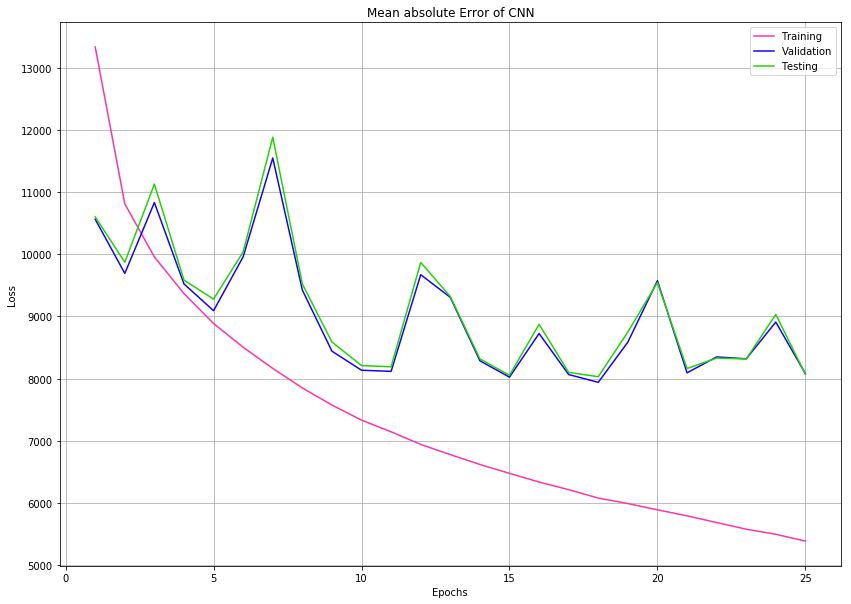

In [59]:
plt.figure(figsize=(14, 10))
history_4 = pd.read_csv("history_4.csv")
plt.ylabel("Loss")
plt.plot(range(1, 26), history_4['loss'], '#ff33a3', label = "Training")
plt.plot(range(1, 26), history_4['val_loss'], '#1300FF', label = "Validation")
plt.plot(range(1, 26), history_4['test_loss'], '#23D300', label = "Testing")
plt.grid(True)
plt.title("Mean absolute Error of CNN")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [60]:
print("MAE on train: ",mean_absolute_error(y_train, model4.predict(Xtrain)))
print("MAE on validation: ",mean_absolute_error(y_val, model4.predict(Xval)))
print("MAE on testing: ", mean_absolute_error(y_test, model4.predict(Xtest)))

MAE on train:  4727.7412600848065
MAE on validation:  8079.333794838059
MAE on testing:  8068.336954943221


In [50]:
#"""Define model trough Model API in Keras"""
embedding_vector = 100
embedding_layer = keras.layers.Embedding(input_dim=len(word_index.keys()),output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = keras.layers.Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)

conv1 = keras.layers.Conv1D(128, 9, activation='relu',padding='same', kernel_regularizer = keras.regularizers.l2(0.01))(embedded_sequences)
conv11 = keras.layers.Conv1D(128, 9, activation='relu',padding='same', kernel_regularizer = keras.regularizers.l2(0.01))(conv1)
pool1 = keras.layers.MaxPooling1D(pool_size = 2)(conv11)
drop1 = keras.layers.Dropout(0.25)(pool1)

conv2 = keras.layers.Conv1D(128, 9, activation='relu',padding='same', kernel_regularizer = keras.regularizers.l2(0.01))(drop1)
conv22 = keras.layers.Conv1D(128, 9, activation='relu',padding='same', kernel_regularizer = keras.regularizers.l2(0.01))(conv2)
pool2 = keras.layers.MaxPooling1D(pool_size = 2)(conv22)
drop2 = keras.layers.Dropout(0.25)(pool2)

conv3 = keras.layers.Conv1D(128, 9, activation='relu',padding='same', kernel_regularizer = keras.regularizers.l2(0.01))(drop2)
conv33 = keras.layers.Conv1D(128, 9, activation='relu',padding='same', kernel_regularizer = keras.regularizers.l2(0.01))(conv3)
pool3 = keras.layers.MaxPooling1D(pool_size = 2)(conv33)
drop3 = keras.layers.Dropout(0.25)(pool3)

flat = keras.layers.Flatten()(drop3)
dense1 = keras.layers.Dense(512, activation="relu")(flat)
dense2 = keras.layers.Dense(256, activation="relu")(dense1)
preds = keras.layers.Dense(1, activation = 'linear')(dense2)
model3 = keras.models.Model(sequence_input, preds)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          14445500  
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 100, 128)          115328    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 100, 128)          147584    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 50, 128)           147584    
__________

In [51]:
model5.compile(loss = 'mae',optimizer='rmsprop',metrics=['acc'])
test_loss = []
test_acc = []
history5 = model5.fit(Xtrain, y_train, validation_data=(Xval, y_val), epochs = 25, batch_size = 128, callbacks=[TestCallback((Xtest, y_test))]).history
history5["test_loss"] = test_loss
history5["test_acc"] = test_acc
pd.DataFrame(history5).to_csv("history_5.csv")

Train on 146860 samples, validate on 61192 samples
Epoch 1/25
146816/146860 [============================>.] - ETA: 0s - loss: 13791.2011 - acc: 4.0867e-05
Testing loss: 17418.198461033677, acc: 5.447216472382613e-05

146860/146860 [==============================] - 80s - loss: 13790.5917 - acc: 4.0855e-05 - val_loss: 17012.7798 - val_acc: 3.2684e-05
Epoch 2/25
146816/146860 [============================>.] - ETA: 0s - loss: 10855.8507 - acc: 2.7245e-05
Testing loss: 10531.887587538471, acc: 0.0

146860/146860 [==============================] - 77s - loss: 10855.7899 - acc: 2.7237e-05 - val_loss: 10446.7774 - val_acc: 6.5368e-05
Epoch 3/25
146816/146860 [============================>.] - ETA: 0s - loss: 10086.2978 - acc: 2.7245e-05
Testing loss: 9933.225899205643, acc: 5.447216472382613e-05

146860/146860 [==============================] - 78s - loss: 10086.9911 - acc: 2.7237e-05 - val_loss: 9871.3501 - val_acc: 4.9026e-05
Epoch 4/25
146816/146860 [============================>.] - ETA

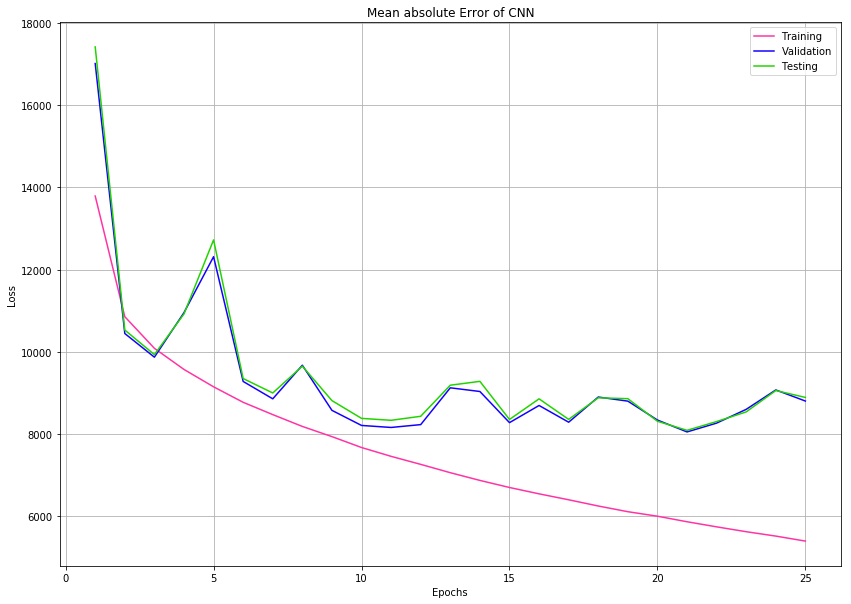

In [55]:
plt.figure(figsize=(14, 10))
history_5 = pd.read_csv("history_5.csv")
plt.ylabel("Loss")
plt.plot(range(1, 26), history_5['loss'], '#ff33a3', label = "Training")
plt.plot(range(1, 26), history_5['val_loss'], '#1300FF', label = "Validation")
plt.plot(range(1, 26), history_5['test_loss'], '#23D300', label = "Testing")
plt.grid(True)
plt.title("Mean absolute Error of CNN")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [56]:
print("MAE on train: ",mean_absolute_error(y_train, model5.predict(Xtrain)))
print("MAE on validation: ",mean_absolute_error(y_val, model5.predict(Xval)))
print("MAE on testing: ", mean_absolute_error(y_test, model5.predict(Xtest)))

MAE on train:  6239.601763152141
MAE on validation:  8803.986596188151
MAE on testing:  8891.80487070521


Podemos observar que en el modelo 4 se obtuvo un menor error que en el modelo 5, pero esta al no estar regularizada no estaba convergiendo, si no que se mantenia constante dentro de un rango, a diferencia del modelo 5 que se nota su convergencia al mirar el gráfico.